# Beta Version
In this notebook, we will perform Bayesian inference (BI) for tension measurements in pendant drop method. Pendant drop is an optical method, 
surface and interfacial tension measurements can be performed optically using pendant drop shape analysis. The shape of the drop hanging from a needle is determined from the balance of forces which include the Surface tension of the liquid being investigated. pendant drop method The surface or interfacial tension can be related to the drop shape by the equation ;
$$γ = ΔρgR_0/β$$
where $γ$ is the surface tension , $Δρ$ is the density difference between fluids , $g$ is the gravitational constant , $R_0$ is the drop radius of curvature at the apex and $β$ is the shape factor.

In this project, assume that other data are known and accurate, and consider only the effect of surface tension $\gamma$ and droplet volume $V_0$ on droplet shape.

First we need to import the image generation codes and some standard libraries.

In [2]:
# image generation codes
from fun_genSingleDrop import *
from fun_opti import *
from fun_preprocess import *

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from numpy import trapz
import random
import math as m

# use Latex for the lables in plots
#plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 22})

# fix the seed for the RNG
RANDOM_SEED=5109
np.random.seed(RANDOM_SEED)



$\sigma=75$ and $V=10$


In [27]:
r_a,z_a=genSingleDrop(sigma=75,volume0=10,rneedle=0.5,output=1)


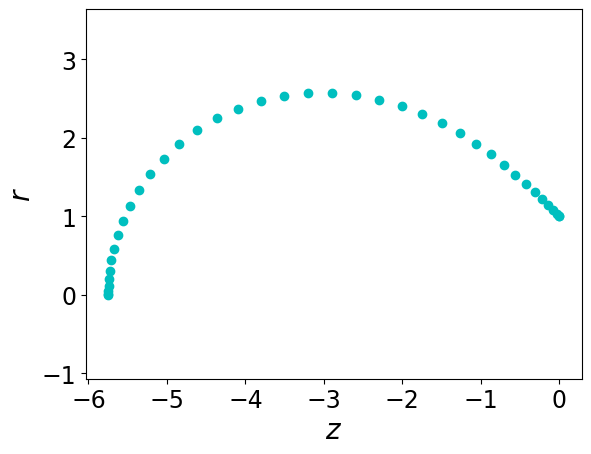

In [28]:
plt.plot(z_a,r_a,'co')
plt.xlabel("$z$",fontdict={'family': 'Times New Roman', 'size':20})
plt.ylabel("$r$",fontdict={'family': 'Times New Roman', 'size':20})
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.axis('equal')
plt.show()

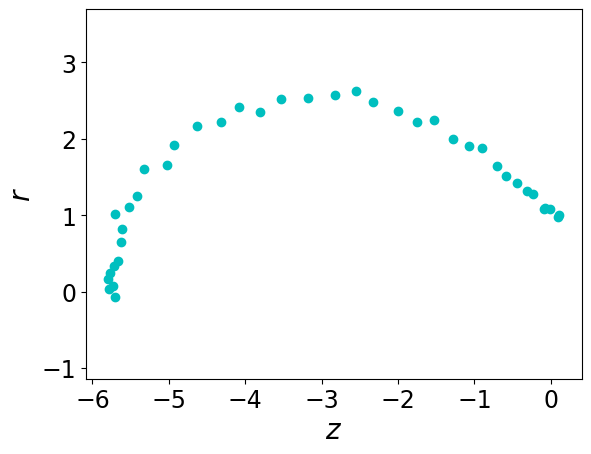

In [29]:
# add white noise on z and r
wn_mu=0
wn_sigma=0.05
r_w=r_a
z_w=z_a

for i in range (r_w.size):
    r_w[i] += random.gauss(wn_mu,wn_sigma)
    z_w[i] += random.gauss(wn_mu,wn_sigma)

plt.plot(z_w,r_w,'co')
plt.xlabel("$z$",fontdict={'family': 'Times New Roman', 'size':20})
plt.ylabel("$r$",fontdict={'family': 'Times New Roman', 'size':20})
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.axis('equal')
plt.show()

In [19]:
def distance(x1, y1, x2, y2): 
    return m.sqrt((x2 - x1)**2 + (y2 - y1)**2)
def arclength(r,z):
    arclength=np.zeros(len(r))
    for i in range(len(r)-1):
        arclength[i+1]=arclength[i]+distance(r[i],z[i],r[i+1],z[i+1])
    return arclength


Text(0, 0.5, '$z$')

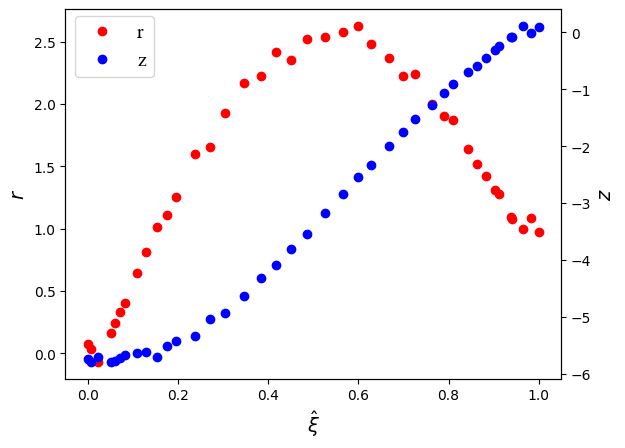

In [30]:
s_w=arclength(r=r_w,z=z_w)
xi_w=s_w/s_w[-1]

fig=plt.figure()

ax=fig.add_subplot(111)
ax.plot(xi_w,r_w,'co',color='r',label='r')

ax2=ax.twinx()
ax2.plot(xi_w,z_w,'co',color='b',label='z')

fig.legend(loc=3, bbox_to_anchor=(0,0.79), bbox_transform=ax.transAxes,prop={'family': 'Times New Roman', 'size':14})
ax.set_xlabel(r'$\hat{\xi}$', fontdict={'family': 'Times New Roman', 'size':16},fontsize=14)
ax.set_ylabel(r"$r$",fontdict={'family': 'Times New Roman', 'size':16},fontsize=14)
ax2.set_ylabel(r"$z$",fontdict={'family': 'Times New Roman', 'size':16},fontsize=14)


Then we use different $V$ and $\sigma$ to generate some drop and calculate their likelihood. 

In [21]:
def vsigma2xi(v,sigma):
    r,z=genSingleDrop(sigma=sigma,volume0=v,rneedle=0.5,output=1)
    return r,z,arclength(r=r,z=z)/arclength(r=r,z=z)[-1]

#r_e1,z_e1,xi_e1=vsigma2xi(v=10,sigma=80)
#r_e2,z_e2,xi_e2=vsigma2xi(v=10,sigma=45)
#r_e3,z_e3,xi_e3=vsigma2xi(v=10,sigma=50)
#r_e4,z_e4,xi_e4=vsigma2xi(v=10,sigma=55)
#r_e5,z_e5,xi_e5=vsigma2xi(v=10,sigma=60)
#r_e6,z_e6,xi_e6=vsigma2xi(v=10,sigma=65)
#r_e7,z_e7,xi_e7=vsigma2xi(v=10,sigma=70)
#r_e8,z_e8,xi_e8=vsigma2xi(v=10,sigma=75)

#r_a,z_a,xi_a=vsigma2xi(v=10,sigma=75)

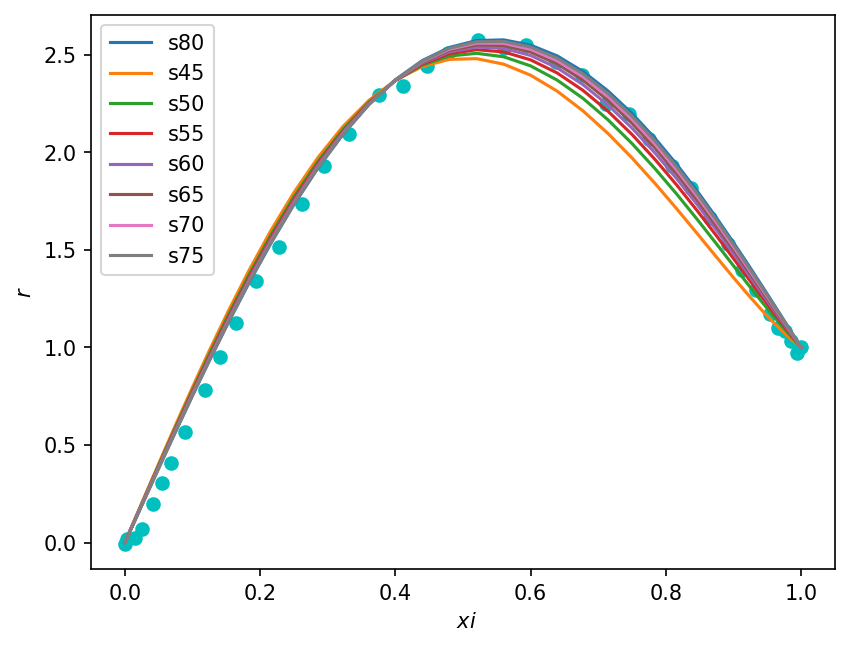

In [12]:
plt.figure(dpi=150)
plt.plot(s_w/s_w[-1],r_w,'co')
plt.plot(xi_e1,r_e1,label='s80')
plt.plot(xi_e2,r_e2,label='s45')
plt.plot(xi_e3,r_e3,label='s50')
plt.plot(xi_e4,r_e4,label='s55')
plt.plot(xi_e5,r_e5,label='s60')
plt.plot(xi_e6,r_e6,label='s65')
plt.plot(xi_e7,r_e7,label='s70')
plt.plot(xi_e8,r_e8,label='s75')
#plt.plot(xi_a,r_a,ls="--",label='real:v10,s75')
plt.xlabel("$\\ xi $")
plt.ylabel("$r$")
plt.legend()
plt.show()

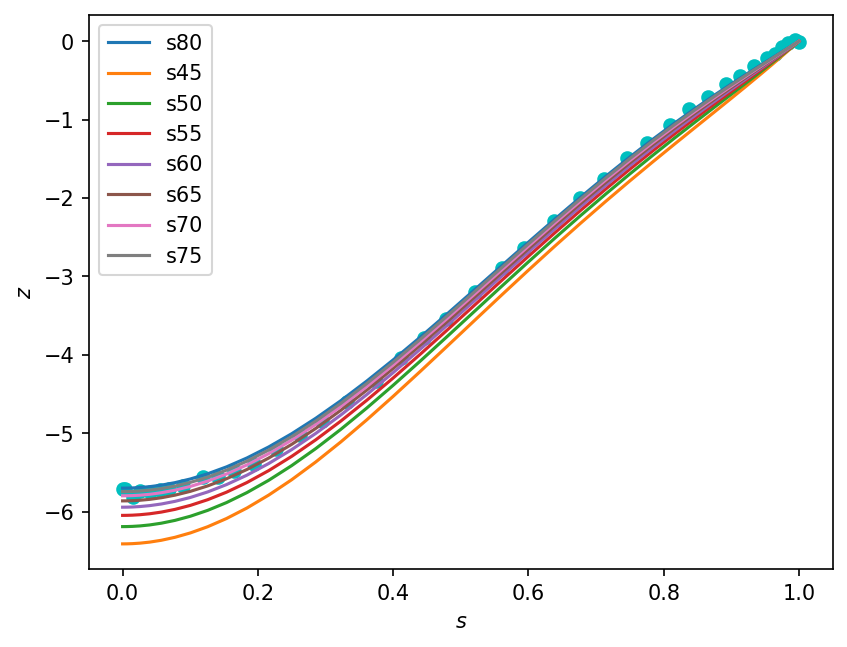

In [13]:
plt.figure(dpi=150)
plt.plot(s_w/s_w[-1],z_w,'co')
plt.plot(xi_e1,z_e1,label='s80')
plt.plot(xi_e2,z_e2,label='s45')
plt.plot(xi_e3,z_e3,label='s50')
plt.plot(xi_e4,z_e4,label='s55')
plt.plot(xi_e5,z_e5,label='s60')
plt.plot(xi_e6,z_e6,label='s65')
plt.plot(xi_e7,z_e7,label='s70')
plt.plot(xi_e8,z_e8,label='s75')
plt.legend()
plt.xlabel("$s$")
plt.ylabel("$z$")
plt.show()

In [9]:
# function: calculate the distance between a point to a line (cross two points)
import numpy as np
def get_distance_from_point_to_line(point, line_point1, line_point2):
    if line_point1 == line_point2:
        point_array = np.array (point)
        point1_array = np.array (line_point1)
        return np.linalg.norm (point_array -point1_array )
# 计算直线的三个参数
    A = line_point2[1] - line_point1[1]
    B = line_point1[0] - line_point2[0]
    C = (line_point1[1] - line_point2[1]) * line_point1[0] + \
        (line_point2[0] - line_point1[0]) * line_point1[1]
# 根据点到直线的距离公式计算距离
    distance = np.abs (A * point [0] + B * point [1] + C) / (np. sqrt (A**2 + B**2))
    return distance

def get_vertical_distance(point,line_point1,line_point2):
    if line_point1 == line_point2:
        point_array = np.array (point)
        point1_array = np.array (line_point1)
        return np.linalg.norm (point_array -point1_array )

    x1,y1=point[0],point[1]
    x2,y2=line_point1[0],line_point1[1]
    x3,y3=line_point2[0],line_point2[1]
    x4=x1

    if x3==x2:
        return np.abs(y1-y2)
    
    y4=(y3*(x4-x2)+y2*(x3-x4))/(x3-x2)
    return np.abs(y1-y4)

def find_point_position(point_x,function_array):
    for j in range(len(function_array)):
            if point_x<=function_array[j]:
                num=j-1
                return num

def get_standard_deviation(x,y,x_obsv,y_obsv):
    import numpy as np
    error=np.zeros(len(x_obsv))
    for i in range(len(y_obsv)):
        point=[x_obsv[i],y_obsv[i]]
        num=find_point_position(point[0],x)
        line_point1=[x[num],y[num]]
        if num+1 > len(x):
             line_point2=line_point1
        else:
             line_point2=[x[num+1],y[num+1]]
        vert_dist=get_vertical_distance(point,line_point1,line_point2)
        error[i]=vert_dist  
    return error

def gauss_prob(data,avg,sig):
    sqrt_2pi=np.power(2*np.pi, 0.5) 
    coef=1/(sqrt_2pi*sig)
    powercoef=-1/(2*np.power (sig, 2)) 
    mypow=powercoef*(np.power ( (data-avg) , 2)) 
    return coef* (np. exp (mypow) )

$$L(\sigma)=\prod_{i=1}^N\frac{1}{\sqrt{2\pi}SD_{noise}} \exp (-\frac{||(r_i^e,z_i^e)-g(\sigma)||}{2SD^2_{noise}})$$





$$L(\sigma)=\prod_{i=1}^N\frac{1}{\sqrt{2\pi}SD_{noise}} \exp (-\frac{(r^i(\sigma)-r_{exp}^i)^2+(z^i(\sigma)-z_{exp}^i)^2}{2SD^2_{noise}})$$


$$L(\sigma)=\prod_{i=1}^N\frac{1}{\sqrt{2\pi}SD_{noise}} \exp (-\frac{\sqrt{(r^i(\sigma)-r_{exp}^i)^2+(z^i(\sigma)-z_{exp}^i)^2}}{2SD^2_{noise}})$$



$SD_{noise}$ is known (0.02), so now we need to measure the $r^i(\sigma)-r^i_{exp}$ and $z^i(\sigma)-z^i_{exp}$

In [10]:
def lhood_sigma(x,y,x_obsv,y_obsv, sd_noise):
    
    error=np.zeros(len(x_obsv))
    for i in range(len(y_obsv)):
        point=[x_obsv[i],y_obsv[i]]
        num=find_point_position(point[0],x)
        line_point1=[x[num],y[num]]    
        if num+1 > len(x):
             line_point2=line_point1
        else:
             line_point2=[x[num+1],y[num+1]]
        vert_dist=get_vertical_distance(point,line_point1,line_point2)
        error[i]=vert_dist
        sqrt_2pi=np.power(2*np.pi, 0.5) 
        lhood_i=1/(sqrt_2pi*sd_noise)*np.exp(-(error[i]**2)/2*sd_noise**2)
        if i==0:
            lhood=lhood_i
        else:
            lhood=lhood*lhood_i
    return lhood


In [11]:
#r_e1,z_e1,xi_e1=vsigma2xi(v=10,sigma=80)
def lhood_sigma_rz(v0,sigma,xi_exp,r_exp,z_exp,sd_noise):
    r_sig,z_sig,xi_sig=vsigma2xi(v=v0,sigma=sigma)
    x=xi_sig
    r=r_sig
    z=z_sig
    error_r=np.zeros(len(xi_exp))
    error_z=np.zeros(len(xi_exp))
    for i in range(len(r_exp)):
        # error in r
        point_r=[xi_exp[i],r_exp[i]]
        num_r=find_point_position(point_r[0],x)
        line_point1_r=[x[num_r],r[num_r]]    
        if num_r+1 > len(x):
             line_point2_r=line_point1_r
        else:
             line_point2_r=[x[num_r+1],r[num_r+1]]
        vert_dist=get_vertical_distance(point_r,line_point1_r,line_point2_r)
        error_r[i]=vert_dist

        # error in z
        point_z=[xi_exp[i],z_exp[i]]
        num_z=find_point_position(point_z[0],x)
        line_point1_z=[x[num_z],z[num_z]]    
        if num_z+1 > len(x):
             line_point2_z=line_point1_z
        else:
             line_point2_z=[x[num_r+1],z[num_z+1]]
        vert_dist=get_vertical_distance(point_z,line_point1_z,line_point2_z)
        error_z[i]=vert_dist

        sqrt_2pi=np.power(2*np.pi, 0.5) 
        lhood_i=1/(sqrt_2pi*sd_noise)*np.exp(-(error_r[i]**2+error_z[i]**2)**0.5/2*sd_noise**2)
        if i==0:
            lhood=lhood_i
        else:
            lhood=lhood*lhood_i
    return lhood

In [31]:
sigma_rz=np.linspace(45,100,num=(100-45+1))
lhood=np.zeros(len(sigma_rz))

for i in range(len(sigma_rz)):
    lhood_sig=lhood_sigma_rz(v0=10,sigma=sigma_rz[i],xi_exp=xi_w,r_exp=r_w,z_exp=z_w,sd_noise=0.02)
    lhood[i]=lhood_sig

lhood_nor=lhood*(np.power(2*np.pi, 0.5)*0.02)**len(xi_w)

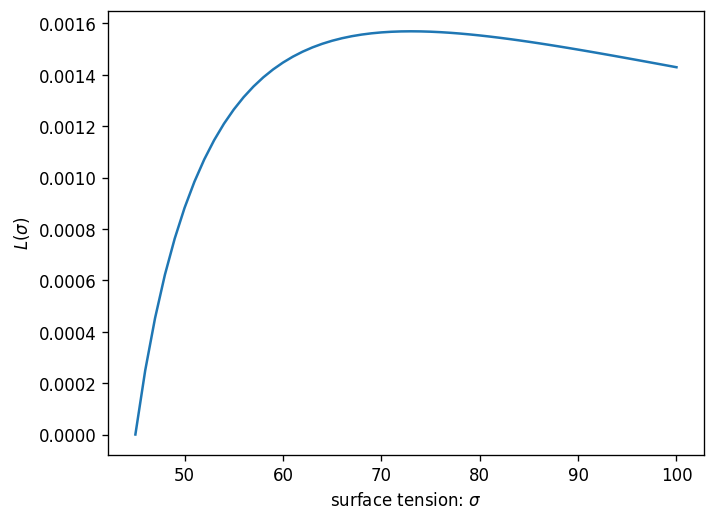

In [19]:
plt.figure(dpi=120)
plt.plot(sigma_rz,lhood_nor-min(lhood_nor))
#plt.plot(xi_a,r_a,ls="--",label='real:v10,s75')
plt.xlabel("surface tension: $\\sigma $")
plt.ylabel("$L(\\sigma)$")

plt.show()

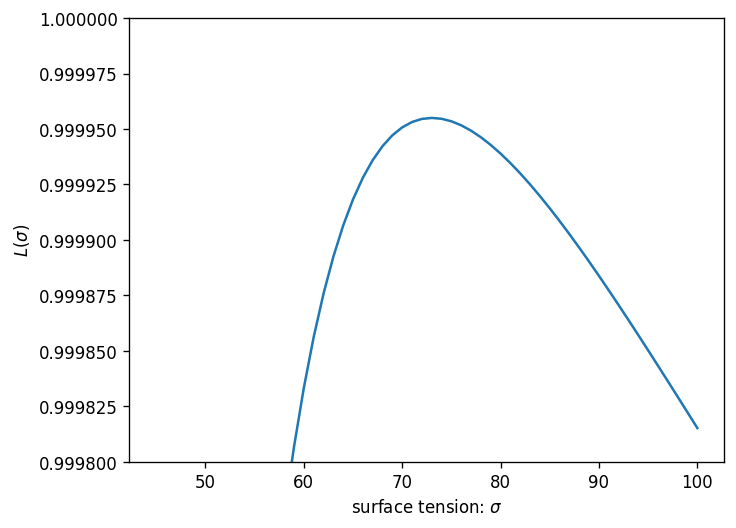

In [20]:
plt.figure(dpi=120)
plt.plot(sigma_rz,lhood_nor)
#plt.plot(xi_a,r_a,ls="--",label='real:v10,s75')
plt.xlabel("surface tension: $\\sigma $")
plt.ylabel("$L(\\sigma)$")
plt.ylim(0.9998,1)
plt.show()

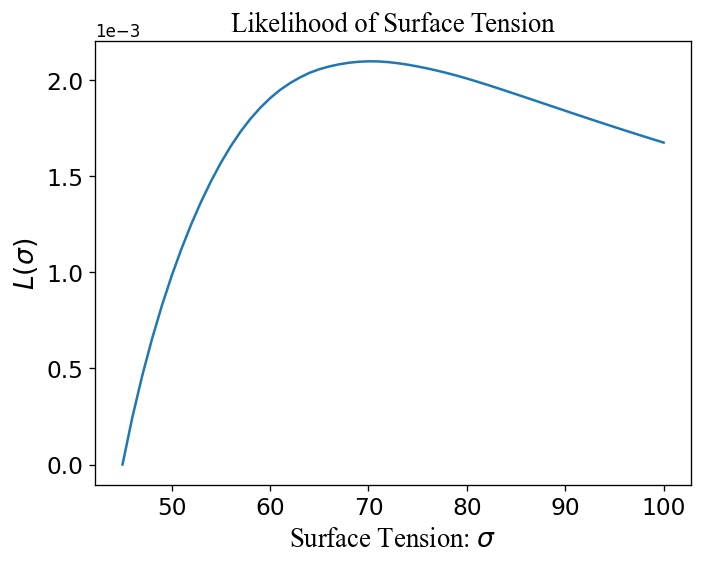

In [32]:
plt.figure(dpi=120)
plt.plot(sigma_rz,lhood_nor-min(lhood_nor))

#plt.plot(xi_a,r_a,ls="--",label='real:v10,s75')
plt.title('Likelihood of Surface Tension',fontdict={'family': 'Times New Roman', 'size':16})
plt.xlabel("Surface Tension: $\\sigma $",fontdict={'family': 'Times New Roman', 'size':16})
plt.ylabel("$L(\\sigma)$",fontdict={'family': 'Times New Roman', 'size':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
plt.show()

In [14]:
def normal(u,sig,x):
    y = np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (m.sqrt(2*m.pi)*sig)
    return y

In [15]:
u_pri,sig_pri=70,10
x_pri = sigma_rz
prior= normal(u_pri,sig_pri,x_pri)
likelihood=(lhood_nor-min(lhood_nor)*0.999)*20
posterior=prior*likelihood

In [24]:
print(sigma_rz[posterior.argmax()],sigma_rz[likelihood.argmax()])

70.0 73.0


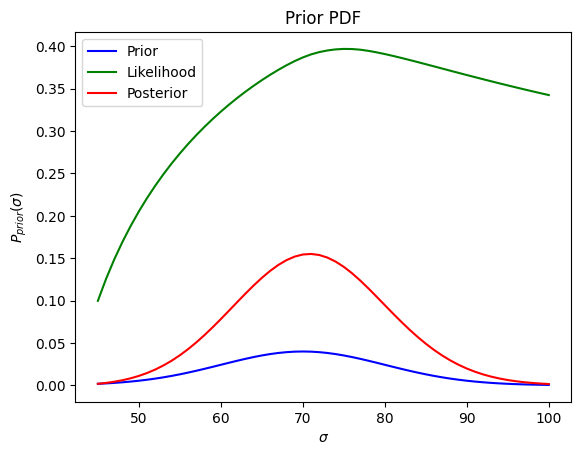

In [16]:
plt.plot(sigma_rz,prior,'blue',label='Prior')
plt.plot(sigma_rz,likelihood*5,'green',label='Likelihood')
plt.plot(sigma_rz,posterior*50,'red',label='Posterior')
plt.xlabel('$\\sigma$')
plt.ylabel('$P_{prior}(\\sigma)$')
plt.title('Prior PDF')
plt.legend()
plt.show()

Text(0.5, 1.0, 'PDF of Prior and Posterior and Likelihood Function')

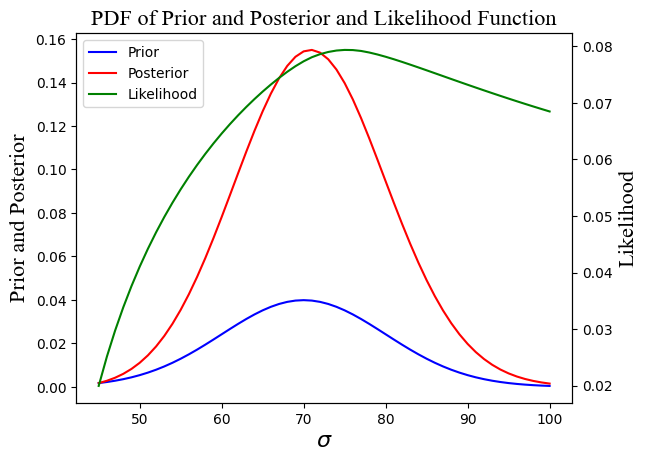

In [17]:
fig=plt.figure()
bx=fig.add_subplot(111)
plt.plot(sigma_rz,prior,'blue',label='Prior')
plt.plot(sigma_rz,posterior*50,'red',label='Posterior')

bx2=bx.twinx()
plt.plot(sigma_rz,likelihood,'green',label='Likelihood')
#plt.ylim(0.9998*5,1)

fig.legend(loc=1, bbox_to_anchor=(0.27,1), bbox_transform=bx.transAxes)
bx.set_xlabel(r'$\sigma$',fontdict={'family': 'Times New Roman', 'size':16})
bx.set_ylabel(r"Prior and Posterior",fontdict={'family': 'Times New Roman', 'size':16})
bx2.set_ylabel(r"Likelihood",fontdict={'family': 'Times New Roman', 'size':16})
plt.title('PDF of Prior and Posterior and Likelihood Function',fontdict={'family': 'Times New Roman', 'size':16})